In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 16 11:05:11 2018

@author: UmnActivity
"""

#%% Libraries
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from dataset import *

#from utils import Logger

# =============================================================================
# Loss/error function to be Maximized for D(x) and minimized D(G(z))
# the logarithm of the probability (e.g. log D(…)) is used in 
# the loss functions instead of the raw probabilies, since 
# using a log loss heavily penalises classifiers that are 
# confident about an incorrect classification.
# =============================================================================



In [2]:
#%% Data pre-processing

# Load data
sampler = data_generator()
data = torch.from_numpy(sampler.sample(1000))
print(type(data))

<class 'torch.Tensor'>


In [3]:
#%% Discriminator

# =============================================================================
# Input a flattened image and return probability of it belonging to real-dataset
# , or sythetic dataset.The input size for each image will be 28x28=784. Regarding 
# the structure of this network, it will have three hidden layers, each followed by
#  a Leaky-ReLU nonlinearity and a Dropout layer to prevent overfitting. 
#  A Sigmoid/Logistic function is applied to the real-valued output to obtain a
#  value in the open-range (0, 1):
# 
# =============================================================================


# D(x,theta2) x = data, theta2 = parameters

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
    
        self.out = nn.Sequential(
            torch.nn.Linear(512, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()



In [4]:

#%% Generator
# =============================================================================
# the Generative Network takes a latent variable vector as input, and returns
#  a 784 valued vector, which corresponds to a flattened 28x28 image.
# =============================================================================

# G(z,theta1) z = noise, theta1 = parameters

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(512, n_out),
            #nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x
generator = GeneratorNet()


#%% Noise Generator

import numpy as np
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    #n = Variable(torch.randn(size, 100))
    return Variable(torch.from_numpy(np.random.normal(size=[size,100]).astype("float32")))

#%% Parameters
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

# =============================================================================
# If we replace vᵢ = D(xᵢ) and yᵢ=1 ∀ i (for all i) in the BCE-Loss definition,
#  we obtain the loss related to the real-images. Conversely if we set vᵢ = D(G(zᵢ))
#  and yᵢ=0 ∀ i, we obtain the loss related to the fake-images.
#PyTorch and most other Machine Learning frameworks usually minimize functions instead.
#Since maximizing a function is equivalent to minimizing it’s negative, and the BCE-Loss 
#term has a minus sign, we don’t need to worry about the sign.
# =============================================================================

In [5]:
#%% Creating label for real and fake data 1- real , 0- fake
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

#%% Training Discriminator 
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

#%% Training Generator
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

#%% Visulization
num_test_samples = 16
test_noise = noise(num_test_samples)

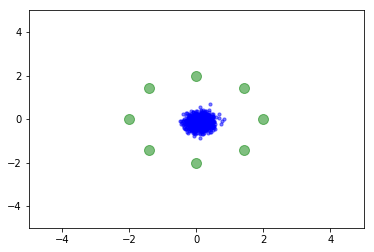

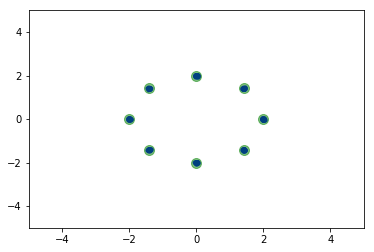

1.4668353 0.81583405


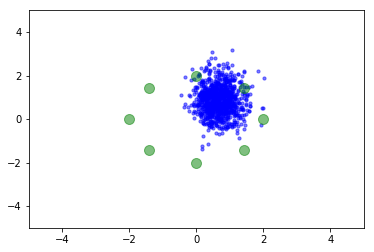

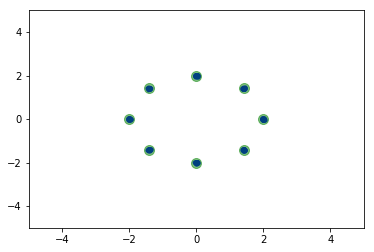

1.1603985 0.86152804


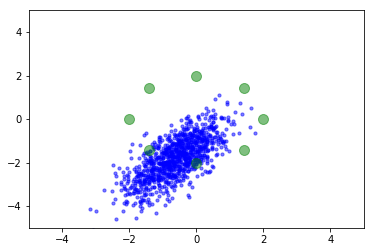

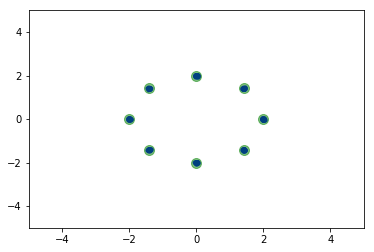

1.0994787 1.1880994


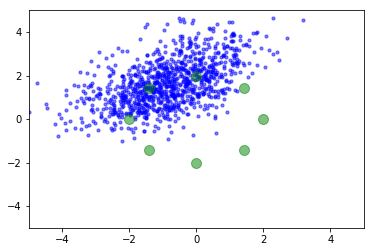

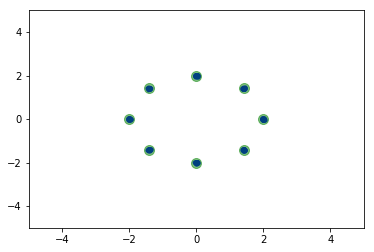

1.1119018 1.3182373


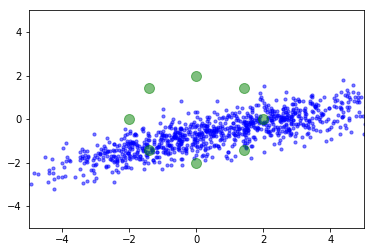

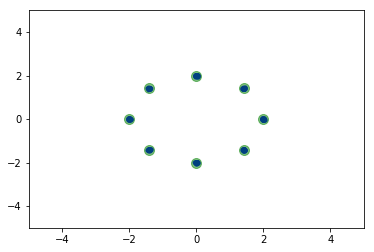

1.4497907 0.7742141


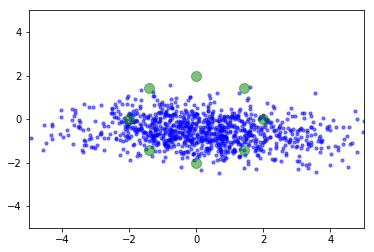

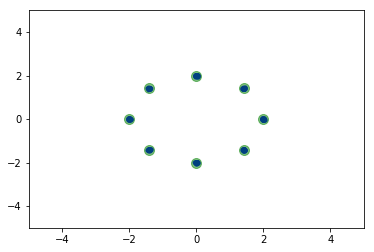

1.2802489 0.80881214


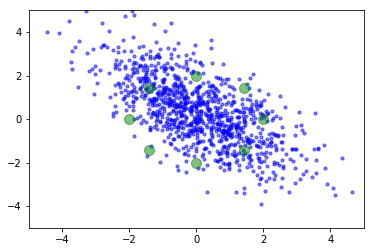

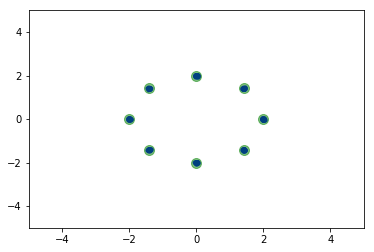

1.4058361 0.7540937


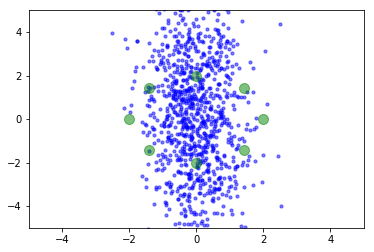

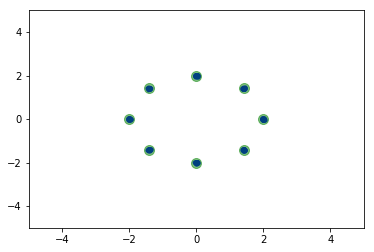

1.4387946 0.805932


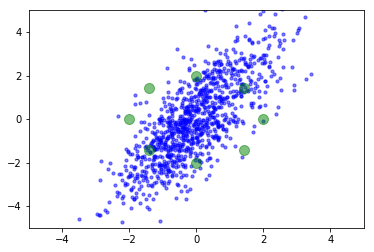

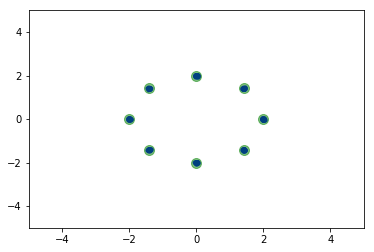

1.2940366 0.7825672


In [ ]:

#%% Final Algo

# Create logger instance
#logger = Logger(model_name='VGAN', data_name='Gaussian')
# Total number of epochs to train
num_epochs = 2000
for epoch in range(num_epochs):
    
    N = data.shape[0]
    real_data = Variable(data)
    fake_data = generator(noise(N))
    
    # Train D
    d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

    # 2. Train Generator
    # Generate fake data
    fake_data = generator(noise(N))
    # Train G
    g_error = train_generator(g_optimizer, fake_data)
    if(epoch%100==0):
        sampler.plot(Variable(fake_data))
        sampler.plot(real_data)
        print(d_error.data.cpu().numpy(), g_error.data.cpu().numpy())
    
